In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimension: (540, 960, 3)


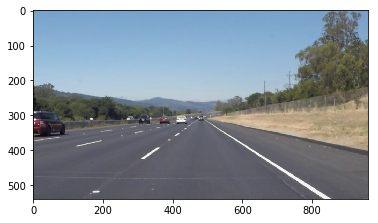

In [6]:
# Reading image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Printing out and ploting 
print('This image is:',type(image),'with dimension:',image.shape)
plt.imshow(image) 

In [15]:
import math

def grayscale(img):
    """ 
    apply Grayscale transform
    and return an image with only
    one color channel
    """
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

def canny(img,min_threshold,max_threshold):
    """
    apply canny transform
    """
    return cv2.Canny(img,min_threshold,max_threshold)

def gaussian_blur(img,kernel_size):
    """
    apply gaussian noise reduction
    """
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)


def region_for_processing(img,vertices):
    """
    apply an image mask. Only keep the region of the image defined by the polygon formed from 'vertices'. The rest image is set to black
    """
    
    mask = np.zeros_like(img)
    
    # defining a blank mask to start with
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
    
    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask,vertices,ignore_mask_color)
    
    # return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

def draw_lines(img, lines, color=[255,0,0], thickness=2):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img,(x1,y1),(x2,y2),color,thickness)
            
            
def hough_lines(img, rho, theta,threshold, min_line_len, max_line_gap):
    """
    'img' should be the output of a canny transform
    returns an image wiht hough lines drawn
    """
    lines = cv2.HoughLinesP(img,rho,theta,threshold,np.array([]),minLineLength=min_line_len,maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
    draw_lines(line_img,lines)
    return line_img

def weighted_img(img, initial_img, m=0.8, n=1, z=0.):
    """
    'img' is the output of hough_lines(), 'initial_img' should be the image before any processing.
    The result image is computed as follows:
    
    initial_img * m + img * n + z
    
    the larger m is , the claear the backgroud is. The larger n is, the thicker the line is.
    """
    return cv2.addWeighted(initial_img,m,img,n,z)  

In [16]:
# test images
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg']

In [17]:
# define and improve function

def line_detect(image):
    
    gray = grayscale(image)
    
    kernel_size = 9
    blur_gray = gaussian_blur(gray,kernel_size)
    
    min_threshold = 10
    max_threshold = 150
    edges = canny(blur_gray, min_threshold, max_threshold)
    
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(int(0.45*imshape[1]), int(0.6*imshape[0])), (int(0.6*imshape[1]), int(0.6*imshape[0])), (imshape[1],imshape[0])]],dtype=np.int32)
    masked_edges = region_for_processing(edges,vertices)
    
    rho = 1                   # distance resolution in piexels of the Hough grid
    theta = np.pi/180         # angular resolution in radians of the Hough grid
    threshold = 30            # minimum number of votes (intersections in Hough grid cell)
    min_line_length =150      # minimum number of pixels making up a line
    max_line_gap = 100        # maximum gap in pixels between connectabel line segments
    
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    result = weighted_img(line_image, image, m=0.8, n=1)
    
    return edges,masked_edges,result

In [18]:
import glob
new_path = os.path.join("test_images/","*.jpg")

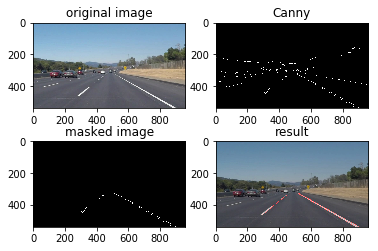

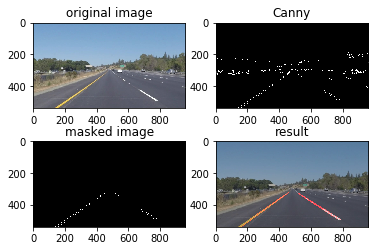

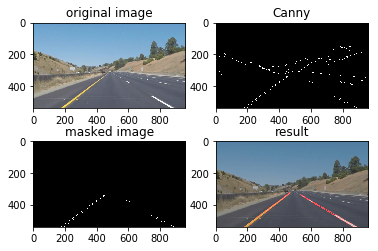

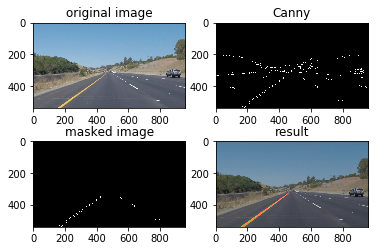

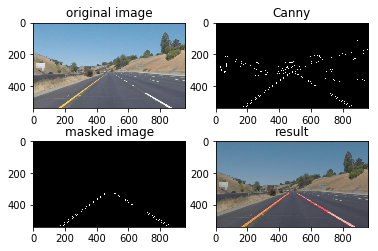

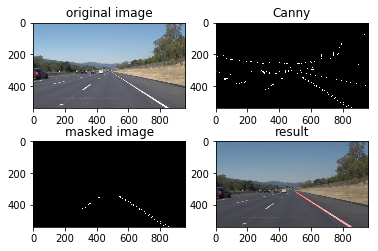

In [19]:
for infile in glob.glob(new_path):
    image = mpimg.imread(infile)
    edges,masked_edges,result = line_detect(image)
    
    plt.figure(figsize=(20,10))
    fig = plt.figure()
    plt.subplot(221)
    plt.title("original image")
    plt.imshow(image)
    
    plt.subplot(222)
    plt.title("Canny")
    plt.imshow(edges,cmap = "gray")
    
    plt.subplot(223)
    plt.title("masked image")
    plt.imshow(masked_edges,cmap = "gray")
    
    plt.subplot(224)
    plt.title("result")
    plt.imshow(result)

In [21]:
# marking the lines in videos

# import packages to edit, save and watch video clips
from moviepy.editor import VideoFileClip 
from IPython.display import HTML

def process_image(image):
    
    edges, masked_edges, result = line_detect(image)
    
    return result


In [23]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:14<00:00, 14.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.3 s, sys: 266 ms, total: 3.56 s
Wall time: 16 s


In [24]:
# play the vedio inline

HTML("""

<video width = "960" height = "540" controls>

  <source src = "{0}">
  
</video>

""".format(white_output))